In [262]:
                                                                        # Programmer: Vishal R. Gangaram
# imports
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy import stats
from scipy.optimize import minimize

%matplotlib inline
quandl.ApiConfig.api_key = ""


#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [263]:
start = pd.to_datetime('2016-11-03')
end = pd.to_datetime('2020-12-10')
api_key = ''
#These are real time data sets
#AAPL_data = quandl.get("EOD/AAPL", authtoken=api_key,start_date=start, end_date=end)

In [264]:
class PortfolioOptimizer: # Class with the capability of constructing a user portfolio and optimizing it
    
    def __init__(self, dataframes=[], stock_names=[], return_df=[], close_df=[],normed_df=[]):
        self.dataframes = dataframes # inputted dataframes from quandl
        self.stock_names = stock_names # names of the stock attributed to each dataframe in self.dataframes
        self.return_df = return_df # list of return arrays from each dataframe in self.dataframes
        self.close_df = close_df # list of close array from each dataframe in self.dataframe
        self.normed_df = normed_df
        
    def add_stock(self, ticker): # Add stock method: adds stock to self.dataframe, pulls from quandl
        self.stock_names.append(ticker)
        ticker = quandl.get("eod/{stock}".format(stock = ticker), authtoken=api_key,start_date=start, end_date=end)
        ticker = ticker.reset_index()
        self.dataframes.append(ticker)
    
    def add_holdings(self, holdings): # Adds the user's current position of each asset in within self.dataframes
        self.holdings = holdings # list that contains the user's current position in each stock within self.dataframes        

    def construct_df(self, column): # Method that constructs a dataframe by concatinating specific arrays 
                                        # that were pulled from each dataframe in self.dataframes
        column_lst = []
        for i in range(len(self.dataframes)): # for loop that looks though each dataframe for the specified array
            column_lst.append(self.dataframes[i][str(column)]) # appends array
        stock_columns = pd.concat(column_lst, axis=1) # concatinates array
        
        if column == 'returns': # if the constructed df is a 'return' dataframe
            self.return_df.append(stock_columns) # append dataframe to self.return_df attribute
        elif column =='Close': # if the consrtucted df is a 'Close' dataframe
                self.close_df.append(stock_columns) # append dataframe to self.close_df attribute
        else: pass
        stock_columns = stock_columns.reset_index()
        return stock_columns # returns constructed dataframe
    
    def get_returns(self): # function that computes returns of a given stock   
        for i in range(len(self.dataframes)): # math involved in computing returns
            self.dataframes[i]['returns'] = self.dataframes[i]['Close'].pct_change(1)
        # doesn't return anything, instead it appends the return column to the already existing pandas df

    def get_log_returns(self): # function that computes logarithmic returns of a given stock
        log_ret = np.log(self.close_df[0] / self.close_df[0].shift(1))
        return log_ret #returns logarithmic return
    
    def calculate_ratio(self, days, ratioType): #calculates portfolio sharpe or sortino ratio of asset r_i
        spy_data = quandl.get("eod/spy", authtoken=api_key, start_date= start, end_date=end) # pings quandl
        close_df = self.close_df[0] # assigns close_df to be first index of close_df (a dataframe within an array)
        log_ret = np.log(self.close_df[0] / self.close_df[0].shift(1))
        str(ratioType).lower() # catches bad inputs, ensures if/else statement works properly
        exp_ret = np.sum((log_ret.mean() * days)) # calculates expected return 
        
        if ratioType == 'sharpe':
            exp_vol = log_ret.std() * np.sqrt(days) # calculates sharpe ratio
            sharpe_ratio = exp_ret / exp_vol
            print('The Sharpe Ratio is: {sharpe} '.format(sharpe=sharpe_ratio))
            self.sharpe_ratio = sharpe_ratio # prints sharpe ratio, assigns sharpe ratio to self.sharpe_ratio
        
        elif ratioType == 'sortino':
            exp_vol = log_ret[log_ret < 0].std() * np.sqrt(days) # same calculation, except only with downward deviation now
            sortino_ratio = exp_ret / exp_vol
            print('The Sortino Ratio is: {sortino} '.format(sortino=sortino_ratio)) # prints sortio ratio
            self.sortino_ratio = sortino_ratio
            
        else:
            pass
        
    def calculate_weights(self): # calculates the weights of portfolio from input array
        self.weights_array = self.holdings/np.sum(self.holdings) # caluclates weights
        #self.weights_array.append(i for i in weights_array)
        return self.weights_array

    def calculate_portfolio_sharpe(self, weights_array, returns_array, days): #calculates sharpe ratio of entire portfolio r_p
        exp_ret = np.sum( (returns_array.mean()  * days)) # Expected return
        exp_vol = returns_array.std() * np.sqrt(days) # Expected volatility
        sharpe_ratio = exp_ret/exp_vol
        print('The Sharpe Ratio is: ')
        return sharpe_ratio # returns sharpe ratio
    
    def get_ret_vol_sr(self):
        log_ret = self.get_log_returns() # gets logarithimic returns
        ret = np.sum(log_ret.mean() * self.weights_array) * 252 # gets returns
        vol = np.sqrt(np.dot(self.weights_array.T, np.dot(log_ret.cov()*252,self.weights_array))) # gets volatility
        sr=ret/vol# sharpe ratio
        return np.array([ret,vol,sr])
    
    def to_dict(self, lst1, lst2): return dict(zip(lst1, lst2))
    
    def plot_column(self, index, column):
        dictionary = self.to_dict(self.stock_names, self.dataframes)
        index = str(index).upper() 
        if  index == 'ALL': # checks if user wants to plot all stocks in portfolio
            fig = go.Figure() # creates figure object
            fig_lst = self.construct_df(column) # creates dataframe depending on what the user asked for
            
            for i in range(len(self.dataframes)):
                fig.add_trace(go.Scatter(
                x=self.dataframes[0]['Date'],
                y=self.dataframes[i][str(column)],
                name=str(self.stock_names[i])))    # this sets its legend entry
                              
            fig.update_layout(title="All " + str(column),
                              xaxis_title="Time",
                              yaxis_title="Asset Value",
                              legend_title="Stocks",
                              font=dict(family="Courier New, monospace",
                                        size=18,
                                        color="RebeccaPurple"))
            fig.show()
        elif index == 'FINAL':
            fig = go.Figure(data=[go.Scatter(x=self.normed_df, 
                                             y=dictionary[index][str(column)])],
                                             layout=go.Layout(title=go.layout.Title(
                                                              text=index + ' ' + str(column))))
            fig.update_layout(
                              xaxis_title="Time",
                              yaxis_title="Positions",
                              font=dict(family="Courier New, monospace",
                                        size=18,
                                        color="RebeccaPurple"))
            fig.show()
        else: # plots self.dataframe[index][str(column)]
            
            fig = go.Figure(data=[go.Scatter(x=dictionary[index]['Date'], 
                                             y=dictionary[index][str(column)])],
                                             layout=go.Layout(title=go.layout.Title(
                                                              text=index + ' ' + str(column))))
            fig.update_layout(
                              xaxis_title="Time",
                              yaxis_title="Asset Value",
                              font=dict(family="Courier New, monospace",
                                        size=18,
                                        color="RebeccaPurple"))
            fig.show()
        
    #def plot_column_candlestick(self, index, column):
        
    def neg_sharpe(self): return self.get_ret_vol_sr()[2] * -1
    def check_sum(self): return np.sum(self.weights_array) - 1   # return 0 if the sum of the weights is 1
    def minimize_volatility(self): return self.get_ret_vol_sr()
    
    
    def normed(self):
        for stock_df in self.dataframes:
            stock_df['Normed Return'] = stock_df['Adj_Close'] / stock_df.iloc[0]['Adj_Close']
        return stock_df['Normed Return'] 
    
    def allocation(self):
        weights_array = self.calculate_weights()
        for stock_df , allo in zip(tuple(self.dataframes), weights_array):
            stock_df['Allocation'] = stock_df['Normed Return']*allo
        return stock_df['Allocation']
        
    def position(self, total_cash):
        for stock_df in tuple(self.dataframes):
            stock_df['Position Values'] = stock_df['Allocation']*total_cash
        return stock_df['Position Values']
    def current_pos(self):
        all_pos_vals = self.construct_df('Position Values')
        all_pos_vals.drop('index', axis =1)
        self.normed_df = all_pos_vals
        #all_pos_vals.columns = self.stock_names
        return all_pos_vals

In [265]:
    ## These two functions are currently broken...
    def get_ret_vol_sr(weights):
        weights = np.array(weights)
        ret = np.sum(log_ret.mean() * weights) * 252
        vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252,weights)))
        sr=ret/vol
        return np.array([ret,vol,sr])
    def neg_sharpe(ret_vol_sr): return ret_vol_sr[2] * -1
    def check_sum(weights_array): return np.sum(weights_array) - 1
    
    def optimizer(neg_sharpe,weights_array): # optimizes portfolio, returns list of floats - eventually will apply floats to self.weights_array
        #def neg_sharpe(self): return self.get_ret_vol_sr()[2] * -1
        cons = ({'type':'eq','fun': check_sum(weights_array)}) # constraints
        bounds = ((0,1),(0,1),(0,1),(0,1)) # bounds
        init_guess = [0.25,0.25,0.25,0.25] # initial guess 
        #neg_sharpe = self.neg_sharpe()
        opt_results = minimize(neg_sharpe, init_guess,method='SLSQP',bounds=bounds,constraints=cons) # scipy minimize function
        return opt_results # optimized via least squares method
        
    def get_frontier_volatility(self): #function that iteratively computes curve on volatility frontier
        
        init_guess = [0.25,0.25,0.25,0.25] # initial guess
        frontier_volatility = [] # create list variable
        for possible_return in frontier_y: # generates list of optimized points on efficient frontier of Markowitz curve
            cons = ({'type':'eq','fun':check_sum()}, # checksum == float, broken here
                {'type':'eq','fun':lambda w: self.get_ret_vol_sr(self.weights_array)[0]-possible_return})
            result = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons) #self.minimize_volatility == float, broken here as well...
            frontier_volatility.append(result['fun'])
        return frontier_volatility # returns list of optimized curve values
    
    def get_returns(dataframes): # function that computes returns of a given stock   
        for i in range(len(dataframes)): # math involved in computing returns
            dataframes[i]['returns'] = dataframes[i]['Close'].pct_change(1)
        # doesn't return anything, instead it appends the return column to the already existing pandas df

    def get_log_returns(close_df): # function that computes logarithmic returns of a given stock
        log_ret = np.log(close_df / close_df.shift(1))
        return log_ret #returns logarithmic return


## Testing

In [266]:
RyanPortfolio = PortfolioOptimizer() # creates instance of PortfolioOptmizer object
holdings = [1,5,7,3,9] # arbitrary holdings array
RyanPortfolio.add_holdings(holdings) # calling add_holdings() method
weights_array = RyanPortfolio.calculate_weights() # calling calculate_weights() method, => that both add_holdings()
                                # and calculate_weights() work properly due to dependencies
weights_array

array([0.04, 0.2 , 0.28, 0.12, 0.36])

In [267]:
# calling add_stock() method, updates PortfolioOptimizer object
RyanPortfolio.add_stock('TSLA')
RyanPortfolio.add_stock('AAPL')
RyanPortfolio.add_stock('GOOGL')
RyanPortfolio.add_stock('DIS')
RyanPortfolio.add_stock("SPY")

RyanPortfolio.stock_names # stock_names attribute updated => add_stock() method works

['TSLA', 'AAPL', 'GOOGL', 'DIS', 'SPY']

In [268]:
# calling get_returns(), returns nothing
RyanPortfolio.get_returns() 

# 'returns' array properly concatinated to original df => get_return() method works
RyanPortfolio.dataframes[0]['Adj_Close'] 

0        37.484
1        38.112
2        38.642
3        38.988
4        38.012
         ...   
1026    568.820
1027    593.380
1028    599.040
1029    641.760
1030    649.880
Name: Adj_Close, Length: 1031, dtype: float64

In [269]:
# calling construct_df() method:
RyanPortfolio.construct_df('returns') # creates 'returns' dataframe
RyanPortfolio.construct_df('Close') # creates 'Close' dataframe

# close_df attribute updated => construct_df() method works 
RyanPortfolio.close_df[0]

,Close,Close,Close,Close,Close
0,187.42,109.83,782.19,93.37,208.779999
1,190.56,108.84,781.10,92.45,208.550003
2,193.21,110.41,802.03,94.43,213.149994
3,194.94,111.06,811.98,94.38,214.110001
4,190.06,110.88,805.59,94.64,216.380005
...,...,...,...,...,...
1026,568.82,123.08,1824.97,153.61,366.790000
1027,593.38,122.94,1821.84,153.24,366.690000
1028,599.04,122.25,1823.76,154.14,369.850000
1029,641.76,123.75,1817.03,153.68,369.090000


In [270]:
# calling calculate_ratio() method:
RyanPortfolio.calculate_ratio(252, 'sharpe') # returns sharpe ratio of each stock in PortfolioOptimizer object

The Sharpe Ratio is: Close    0.840406
Close    1.085245
Close    2.903084
Close    2.793496
Close    3.995289
dtype: float64 


In [271]:
RyanPortfolio.plot_column('all','returns') # checks if first condition works# Calling plot_column() function:


In [272]:
RyanPortfolio.plot_column('TSLA','Close') #checks if second condition works

In [273]:
RyanPortfolio.dataframes[0].head()

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,returns
0,2016-11-03,189.000,191.47,187.0401,187.42,2653023.0,0.0,1.0,37.800,38.294,37.40802,37.484,13265115.0,NaN
1,2016-11-04,189.000,193.46,185.9600,190.56,5146043.0,0.0,1.0,37.800,38.692,37.19200,38.112,25730215.0,0.016754
2,2016-11-07,193.590,194.29,190.0500,193.21,3870112.0,0.0,1.0,38.718,38.858,38.01000,38.642,19350560.0,0.013906
3,2016-11-08,193.790,197.49,191.2600,194.94,3267580.0,0.0,1.0,38.758,39.498,38.25200,38.988,16337900.0,0.008954
4,2016-11-09,186.875,192.00,183.9500,190.06,8173065.0,0.0,1.0,37.375,38.400,36.79000,38.012,40865325.0,-0.025033


In [274]:
ret_vol_sr = RyanPortfolio.get_ret_vol_sr()
dd = neg_sharpe(ret_vol_sr)
dd

-0.49767956637005595

In [275]:
cons = ({'type':'eq','fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

In [276]:
results = opt_results.x
results_col = pd.DataFrame(results)
results_col.columns = ['Results']
results_col

,Results
0,0.000000e+00
1,0.000000e+00
2,1.000000e+00
3,5.551115e-17


In [277]:
RyanPortfolio.normed() # normalized return

0       1.000000
1       0.998898
2       1.020931
3       1.025529
4       1.036402
          ...   
1026    1.898149
1027    1.897632
1028    1.913985
1029    1.910052
1030    1.915641
Name: Normed Return, Length: 1031, dtype: float64

In [278]:
RyanPortfolio.allocation() # portfolio allocation

0       0.360000
1       0.359603
2       0.367535
3       0.369191
4       0.373105
          ...   
1026    0.683334
1027    0.683148
1028    0.689035
1029    0.687619
1030    0.689631
Name: Allocation, Length: 1031, dtype: float64

In [279]:
RyanPortfolio.position(1000) # entering amount of money

0       360.000000
1       359.603417
2       367.535196
3       369.190539
4       373.104714
           ...    
1026    683.333818
1027    683.147517
1028    689.034632
1029    687.618743
1030    689.630795
Name: Position Values, Length: 1031, dtype: float64

In [280]:
RyanPortfolio.current_pos()

,index,Position Values,Position Values,Position Values,Position Values,Position Values
0,0,40.000000,200.000000,280.000000,120.000000,360.000000
1,1,40.670153,198.197214,279.609813,118.817607,359.603417
2,2,41.235727,201.056178,287.102111,121.362322,367.535196
3,3,41.604951,202.239825,290.663905,121.298061,369.190539
4,4,40.563440,201.912046,288.376481,121.632216,373.104714
...,...,...,...,...,...,...
1026,1026,607.000320,946.718569,653.283218,207.756325,683.333818
1027,1027,633.208836,945.641704,652.162774,207.255903,683.147517
1028,1028,639.248746,940.334296,652.850075,208.473146,689.034632
1029,1029,684.836197,951.872140,650.440941,207.850999,687.618743


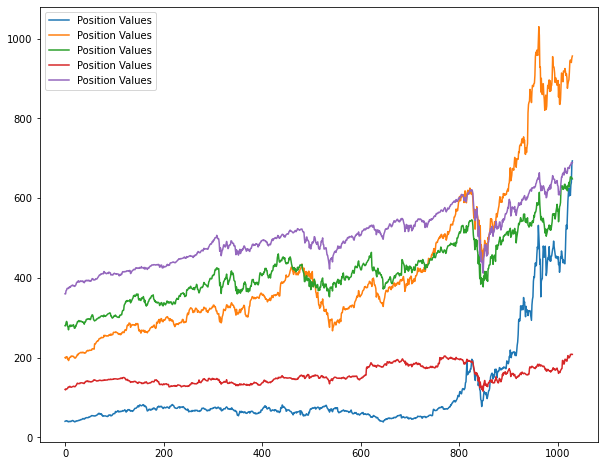

In [281]:
RyanPortfolio.current_pos().drop('index', axis=1,).plot(figsize = (10,8))